# Lecture 10

## Introduction to Regressions <a class="anchor" id="TOC"></a>

 - Binary means (close vs far)         
 - Pre-specified categories with means 
 - Non-parametric regression (lowess)  
 - Simple linear regression (OLS)        
                                     
#### Case-study:                           
- Hotels Vienna          
                                     
#### Dataset:                              
- hotels-vienna


___

Import packages

In [1]:
import pandas as pd
import numpy as np
from plotnine import *
import warnings

warnings.filterwarnings("ignore")

From OSF import hotel-vienna data

In [2]:
hotels = pd.read_csv("https://osf.io/y6jvb/download")

In [3]:
hotels

,country,city_actual,rating_count,center1label,center2label,neighbourhood,price,city,stars,ratingta,...,offer_cat,year,month,weekend,holiday,distance,distance_alter,accommodation_type,nnights,rating
0,Austria,Vienna,36.0,City centre,Donauturm,17. Hernals,81,Vienna,4.0,4.5,...,15-50% offer,2017,11,0,0,2.7,4.4,Apartment,1,4.4
1,Austria,Vienna,189.0,City centre,Donauturm,17. Hernals,81,Vienna,4.0,3.5,...,1-15% offer,2017,11,0,0,1.7,3.8,Hotel,1,3.9
2,Austria,Vienna,53.0,City centre,Donauturm,Alsergrund,85,Vienna,4.0,3.5,...,15-50% offer,2017,11,0,0,1.4,2.5,Hotel,1,3.7
3,Austria,Vienna,55.0,City centre,Donauturm,Alsergrund,83,Vienna,3.0,4.0,...,15-50% offer,2017,11,0,0,1.7,2.5,Hotel,1,4.0
4,Austria,Vienna,33.0,City centre,Donauturm,Alsergrund,82,Vienna,4.0,3.5,...,15-50% offer,2017,11,0,0,1.2,2.8,Hotel,1,3.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423,Austria,Vienna,2.0,City centre,Donauturm,Wieden,109,Vienna,3.0,3.0,...,50%-75% offer,2017,11,0,0,1.5,3.8,Apartment,1,5.0
424,Austria,Vienna,145.0,City centre,Donauturm,Wieden,185,Vienna,5.0,4.0,...,15-50% offer,2017,11,0,0,0.8,3.6,Hotel,1,4.3
425,Austria,Vienna,112.0,City centre,Donauturm,Wieden,100,Vienna,4.0,4.5,...,0% no offer,2017,11,0,0,1.0,3.7,Hotel,1,4.4
426,Austria,Vienna,169.0,City centre,Donauturm,Wieden,58,Vienna,3.0,3.0,...,15-50% offer,2017,11,0,0,1.4,4.1,Hotel,1,3.2


Apply filters:  3-4 stars, Vienna actual, without  extreme prices

In [4]:
hotels = (
    hotels.loc[lambda x: x["accommodation_type"] == "Hotel"]
    .loc[lambda x: x["city_actual"] == "Vienna"]
    .loc[lambda x: x["stars"] >= 3]
    .loc[lambda x: x["stars"] <= 4]
    .loc[lambda x: x["stars"].notnull()]
    .loc[lambda x: x["price"] <= 600]
)

Summary statistics on price and distance

In [5]:
hotels.filter(["price", "distance"]).describe(percentiles=[0.25, 0.5, 0.75, 0.95]).T

,count,mean,std,min,25%,50%,75%,95%,max
price,207.0,109.975845,42.221381,50.0,82.0,100.0,129.5,183.4,383.0
distance,207.0,1.529952,1.161507,0.0,0.8,1.3,1.9,3.9,6.6


Graphical investigation: \
create a base scatter-plot between price and distance

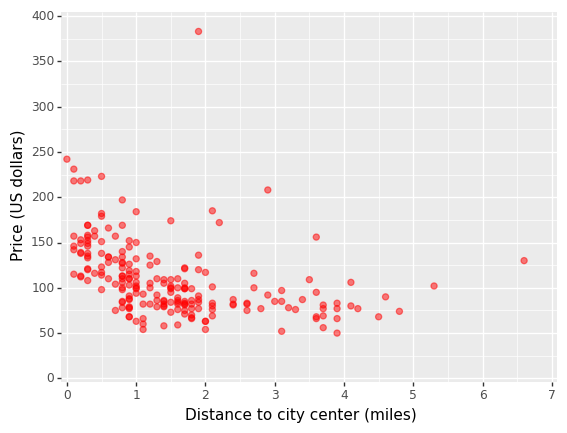

<ggplot: (400619127)>

In [6]:
p1  = (
    ggplot(data=hotels)
    + geom_point(aes(x="distance", y="price"), color="red", size=2, alpha=0.5)
    + expand_limits(x=0.01, y=0.01)
    + scale_x_continuous(expand=(0.01, 0.01), limits=(0, 7), breaks=range(0, 8))
    + scale_y_continuous(
        expand=(0.01, 0.01), limits=(0, 400), breaks=np.arange(0, 401,50)
    )
    + labs(x="Distance to city center (miles)", y="Price (US dollars)")
)
p1

### REGRESSION 1: 

Close vs Far away hotels with a binary variable: 
 - if further away from 2 miles, consider as 'far', otherwise 'close'

In [7]:
hotels["dist2"] = np.where(hotels["distance"] >= 2, "Far", "Close")
hotels["Eprice_cat2"] = hotels.groupby("dist2")["price"].transform("mean")

Check the descriptives for the two categories:

In [8]:
(
    hotels.melt(id_vars="dist2", value_vars=["distance", "price"], value_name = "price")
    .groupby(["dist2", "variable"])
    .agg(["mean", "std", "min", "max", "count"])
    .round(2)
)

price                          
                  mean    std   min    max count
dist2 variable                                  
Close distance    0.99   0.54   0.0    1.9   157
      price     116.43  43.10  54.0  383.0   157
Far   distance    3.21   0.97   2.0    6.6    50
      price      89.72  32.09  50.0  208.0    50

Plot the two categories

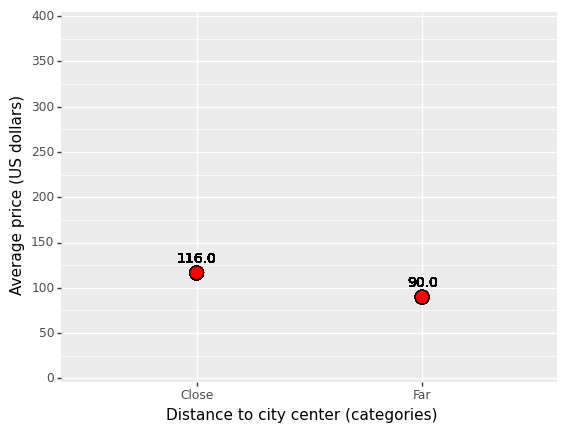

<ggplot: (400759307)>

In [9]:
(
    ggplot(data=hotels)
    + geom_point(
        aes(x="dist2", y="Eprice_cat2"), size=5, alpha=0.4, fill="red", na_rm=True
    )
    + geom_text(
        aes(x="dist2", y="Eprice_cat2 + 16" , label="round(Eprice_cat2, 0)"),
        color="black",
        size=10,
    )
    + scale_y_continuous(
        expand=(0.01, 0.01), limits=(0, 400), breaks=np.arange(0, 401, 50)
    )
    + expand_limits(y=0.01)
    + scale_x_discrete()
    + labs(x="Distance to city center (categories)", y="Average price (US dollars)")
)

### Task:
Instead of a simple dot, use a box-plot, which shows the underlying (conditional) distribution better!

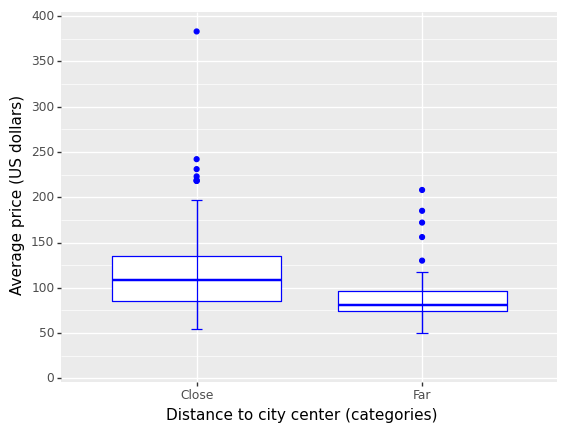

<ggplot: (401198002)>

In [10]:
(
    ggplot(hotels, aes(x="dist2", y="price"))
    + geom_boxplot(color="blue")
    + stat_boxplot(geom="errorbar", width=0.05, size=0.5, color="blue")
    + scale_y_continuous(
        expand=(0.01, 0.01), limits=(0, 400), breaks=np.arange(0, 401, 50)
    )
    + expand_limits(y=0.01)
    + scale_x_discrete()
    + labs(x="Distance to city center (categories)", y="Average price (US dollars)")
)

### REGRESSION 2: 4 DISTANCE CATEGORIES:

Below 1, between 1 and 2, between 2 and 3 and above 3 -> x value will be the midpoint

In [11]:
hotels["dist4"] = (
    0.5
    + np.where(hotels["distance"] >= 1, 1, 0)
    + np.where(hotels["distance"] >= 2, 1, 0)
    + np.where(hotels["distance"] >= 3, 2.5, 0)
)

Add mean values for price given each group

In [12]:
hotels["Eprice_cat4"] = hotels.groupby("dist4")["price"].transform("mean")

In [13]:
(
    hotels.melt(id_vars="dist4", value_vars=["distance", "price"], value_name = "price")
    .groupby(["dist4", "variable"])
    .agg(["mean", "std", "min", "max", "count"])
    .round(2)
)

price                          
                  mean    std   min    max count
dist4 variable                                  
0.5   distance    0.55   0.28   0.0    0.9    81
      price     132.91  38.54  68.0  242.0    81
1.5   distance    1.46   0.29   1.0    1.9    76
      price      98.86  40.89  54.0  383.0    76
2.5   distance    2.35   0.32   2.0    2.9    22
      price      97.55  40.39  54.0  208.0    22
5.0   distance    3.88   0.76   3.0    6.6    28
      price      83.57  22.60  50.0  156.0    28

Make a graph for each segment

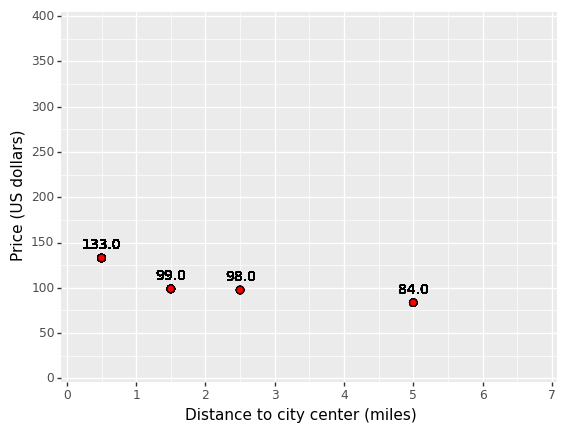

<ggplot: (401220762)>

In [14]:
(
    ggplot(data=hotels)
    + geom_point(
        aes(x="dist4", y="Eprice_cat4"), size=2.5, fill="red", alpha=0.4, na_rm=True
    )
    + geom_text(
        aes(x="dist4", y="Eprice_cat4 + 15", label="round(Eprice_cat4)"),
        color="black",
        size=10,
    )
    + expand_limits(x=0.01, y=0.01)
    + coord_cartesian(xlim=(0, 7), ylim=(0, 400))
    + scale_y_continuous(
        expand=(0.01, 0.01), limits=(0, 400), breaks=np.arange(0, 401, 50)
    )
    + scale_x_continuous(
        expand=(0.01, 0.01), limits=(0, 7), breaks=[0, 1, 2, 3, 4, 5, 6, 7]
    )
    + labs(x="Distance to city center (miles)", y="Price (US dollars)")
)

What actually is happening is a: \
scatterplot with step function (we use 1km bits for simplicity using 4 bits for 3-7km)

In [15]:
hotels["dist4_s"] = (
    np.where(hotels["distance"] >= 1, 1, 0)
    + np.where(hotels["distance"] >= 2, 1, 0)
    + np.where(hotels["distance"] >= 3, 1, 0)
    + np.where(hotels["distance"] >= 4, 1, 0)
    + np.where(hotels["distance"] >= 5, 1, 0)
    + np.where(hotels["distance"] >= 6, 1, 0)
)

hotels["xend"] = hotels["dist4_s"] + 1
hotels["yend"] = hotels["Eprice_cat4"]

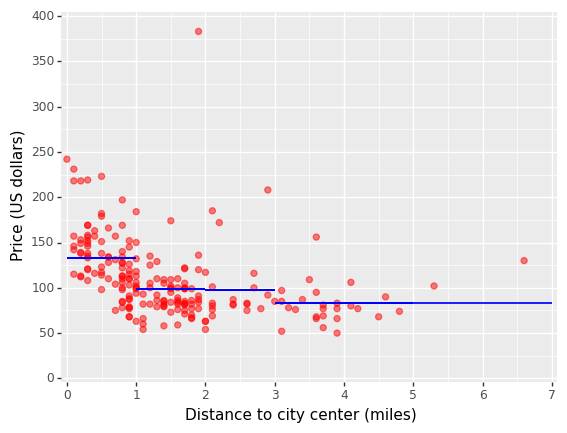

<ggplot: (401389974)>

In [16]:
p1 + geom_segment(
    aes(x="dist4_s", y="yend", xend="xend", yend="yend"),
    color="blue",
    size=0.7,
    na_rm=True,
)

### Task

REGRESSION 3: use 7 different categories/bins based on distance: \
below 1, between:
          1 and 2
          2 and 3
          ...
          6 and 7

In [17]:
hotels["dist7_new"] = (
    0.5
    + np.where(hotels["distance"] >= 1, 1, 0)
    + np.where(hotels["distance"] >= 2, 1, 0)
    + np.where(hotels["distance"] >= 3, 1, 0)
    + np.where(hotels["distance"] >= 4, 1, 0)
    + np.where(hotels["distance"] >= 5, 1, 0)
    + np.where(hotels["distance"] >= 6, 1, 0)
)

In [18]:
hotels["Eprice_cat7_new"] = hotels.groupby("dist7_new")["price"].transform("mean")

In [19]:
(
    hotels.melt(id_vars="dist7_new", value_vars=["distance", "price"], value_name = "price")
    .groupby(["dist7_new", "variable"])
    .agg(["mean", "std", "min", "max", "count"])
    .round(2)
)

price                           
                      mean    std    min    max count
dist7_new variable                                   
0.5       distance    0.55   0.28    0.0    0.9    81
          price     132.91  38.54   68.0  242.0    81
1.5       distance    1.46   0.29    1.0    1.9    76
          price      98.86  40.89   54.0  383.0    76
2.5       distance    2.35   0.32    2.0    2.9    22
          price      97.55  40.39   54.0  208.0    22
3.5       distance    3.52   0.30    3.0    3.9    20
          price      80.65  23.15   50.0  156.0    20
4.5       distance    4.38   0.29    4.1    4.8     6
          price      82.50  13.62   68.0  106.0     6
5.5       distance    5.30    NaN    5.3    5.3     1
          price     102.00    NaN  102.0  102.0     1
6.5       distance    6.60    NaN    6.6    6.6     1
          price     130.00    NaN  130.0  130.0     1

Scatterplot with step function, starting point is simply at cut-off

In [20]:
hotels["dist7_s"] = (
    np.where(hotels["distance"] >= 1, 1, 0)
    + np.where(hotels["distance"] >= 2, 1, 0)
    + np.where(hotels["distance"] >= 3, 1, 0)
    + np.where(hotels["distance"] >= 4, 1, 0)
    + np.where(hotels["distance"] >= 5, 1, 0)
    + np.where(hotels["distance"] >= 6, 1, 0)
)

In [21]:
hotels["xend"] = hotels["dist7_s"] + 1
hotels["yend"] = hotels["Eprice_cat7_new"]

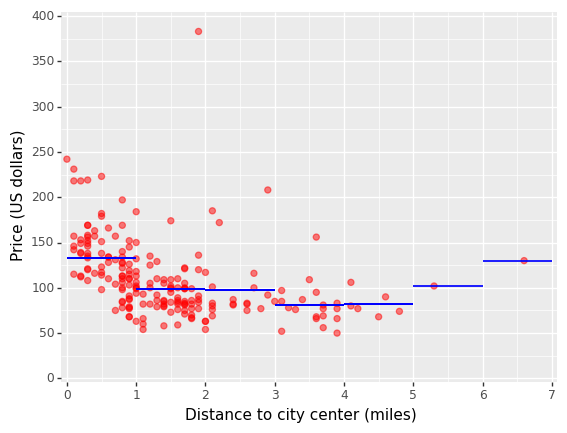

<ggplot: (400619244)>

In [22]:
p1 + geom_segment(
    aes(x="dist7_s", y="yend", xend="xend", yend="yend"),
    color="blue",
    size=0.7,
    na_rm=True,
)

###  LOWESS NONPARAMETRIC REGRESSION

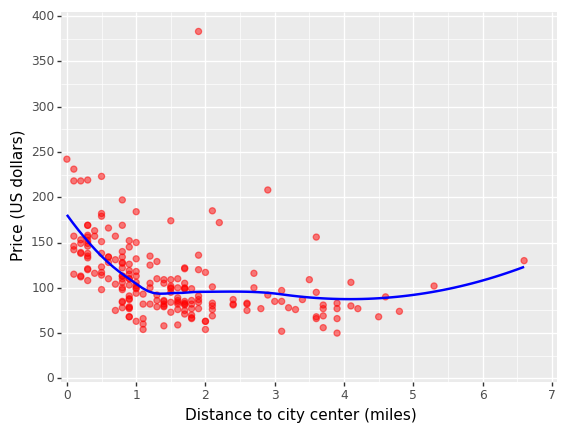

<ggplot: (400762580)>

In [23]:
p1 + geom_smooth(aes(x="distance", y="price"), color="blue", method="loess", se=False)

- Advantage: \
   smooth curve which represent the pattern of association pretty flexibly!
-  Disadvantage: \
   no measurable properties: it smooth over the observations with an 'optimal' bandwidth.

## Solution: linear regression

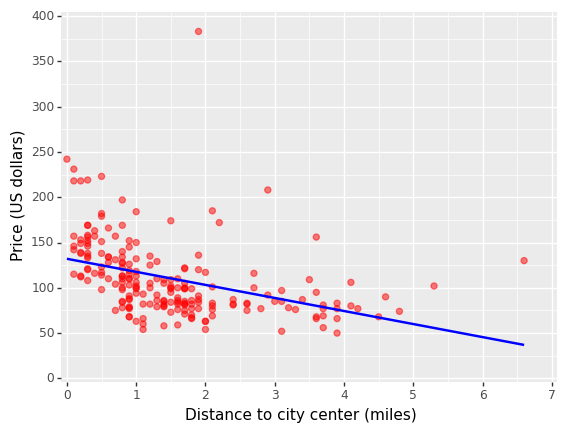

<ggplot: (401512067)>

In [24]:
p1 + geom_smooth(
    aes(x="distance", y="price"), method="lm", color="blue", formula="y~x", se=False
)

How to quantify linear regression: \
Remember: $y = \alpha + \beta * x + \epsilon$

In Python, the [statsmodels](https://www.statsmodels.org/stable/index.html) package is usually used to estimate regressions

In [25]:
import statsmodels.formula.api as smf
from mizani.formatters import percent_format

We use the statsmodels formula api, where you can give the equations as a string

 Simple model, with homoskedastic SE

In [26]:
simple_reg = smf.ols("price ~ distance", data=hotels).fit()
simple_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.157
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     38.20
Date:                Tue, 19 Jul 2022   Prob (F-statistic):           3.39e-09
Time:                        17:19:07   Log-Likelihood:                -1050.3
No. Observations:                 207   AIC:                             2105.
Df Residuals:                     205   BIC:                             2111.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    132.0170      4.474     29.511      0.000     123.197     140.837
distance     -14.4064      2.331     -6.181      0.000     -19.002      -9.811
==============================================================================
Omnibus:                      141.994   Durbin-Watson:                   1.479
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1560.025
Skew:                           2.497   Prob(JB):                         0.00
Kurtosis:                      15.488   Cond. No.                         3.78
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Simple model, with heteroskedastic robust SE

In [27]:
hetero_rob_reg = smf.ols("price ~ distance", data=hotels).fit(cov_type ="HC3")
hetero_rob_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.157
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     28.10
Date:                Tue, 19 Jul 2022   Prob (F-statistic):           2.97e-07
Time:                        17:19:07   Log-Likelihood:                -1050.3
No. Observations:                 207   AIC:                             2105.
Df Residuals:                     205   BIC:                             2111.
Df Model:                           1                                         
Covariance Type:                  HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    132.0170      4.876     27.072      0.000     122.459     141.575
distance     -14.4064      2.718     -5.301      0.000     -19.733      -9.080
==============================================================================
Omnibus:                      141.994   Durbin-Watson:                   1.479
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1560.025
Skew:                           2.497   Prob(JB):                         0.00
Kurtosis:                      15.488   Cond. No.                         3.78
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

Its wasy to compare two regression output tables using the stargazer package

In [28]:
from stargazer.stargazer import Stargazer

In [29]:
table = Stargazer([simple_reg, hetero_rob_reg])
table.rename_covariates({"Intercept": "Constant"})
table.custom_columns(["Homoskedastic SE", "Heteroskedastic robust SE"], [1, 1])
table

## Analysis of the results:
   - price prediction of a model
   - errors of predictions

It is easy to save the predicted values and residuals

In [30]:
hotels["predprice"] = simple_reg.fittedvalues
hotels["e"] = simple_reg.resid

Get the hotel, which is the most underpriced

In [31]:
hotels.sort_values(by="e").head(1)

,country,city_actual,rating_count,center1label,center2label,neighbourhood,price,city,stars,ratingta,...,dist4,Eprice_cat4,dist4_s,xend,yend,dist7_new,Eprice_cat7_new,dist7_s,predprice,e
153,Austria,Vienna,63.0,City centre,Donauturm,Josefstadt,54,Vienna,3.0,3.0,...,1.5,98.855263,1,2,98.855263,1.5,98.855263,1,116.16991,-62.16991


probably we are only interested in hotel_id, distance, price, prediction and error values:

In [32]:
hotels.sort_values(by="e").head(1).filter(["hotel_id","distance","price","predprice","e"])

,hotel_id,distance,price,predprice,e
153,22080,1.1,54,116.16991,-62.16991


 Interpret the result!

We can get the 5 most overpriced five hotels

In [33]:
hotels.sort_values(by="e", ascending=False).head(5).filter(
    ["hotel_id", "distance", "price", "predprice", "e"]
)

,hotel_id,distance,price,predprice,e
247,22193,1.9,383,104.644774,278.355226
26,21930,2.9,208,90.238353,117.761647
128,22050,0.0,242,132.016973,109.983027
110,22031,0.1,231,130.576331,100.423669
129,22051,0.5,223,124.813762,98.186238


Checking the histogram of residuals:\
we can better understand about how well we can predict the prices\
notes:\
   - we picked previously the smallest and 5 largest values from here
   - on average we will have 0 error, as this is a property of the OLS estimator

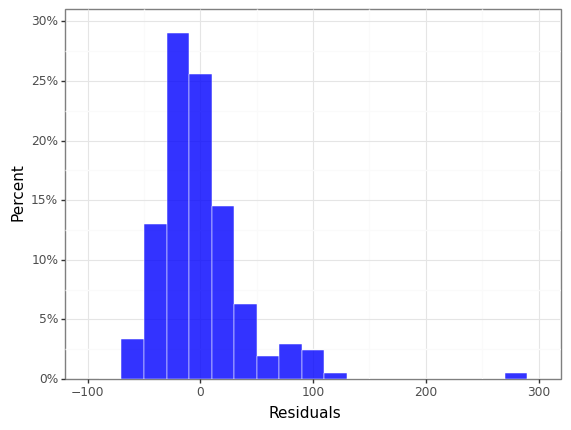

<ggplot: (679504602)>

In [34]:
(
    ggplot(hotels, aes(x="e"))
    + geom_histogram(
        aes(y=after_stat("count / np.sum(count)")),
        binwidth=20,
        fill="blue",
        color="white",
        size=0.2,
        alpha=0.8,
        na_rm=True,
    )
    + labs(x="Residuals", y="Percent")
    + scale_x_continuous(limits=(-100, 300), breaks=np.arange(-100, 301, 100))
    + scale_y_continuous(
        expand=(0.0, 0.0),
        limits=(0, 0.31),
        breaks=np.arange(0, 0.31, 0.05),
        labels=percent_format(),
    )
    + theme_bw()
)

We can make a pretty graph with the bottom and top 5 deals:

Create a factor variable with 4 possible values

In [35]:
hotels["reg1_res"] = np.where(hotels["e"] >= 0, "overpriced", "underpriced")

hotels["reg1_res"] = np.where(
    hotels["hotel_id"].isin(
        hotels.sort_values(by="e", ascending=False).head(5)["hotel_id"].tolist()
    ),
    "top5",
    hotels["reg1_res"],
)
hotels["reg1_res"] = np.where(
    hotels["hotel_id"].isin(
        hotels.sort_values(by="e", ascending=False).tail(5)["hotel_id"].tolist()
    ),
    "bottom5",
    hotels["reg1_res"],
)

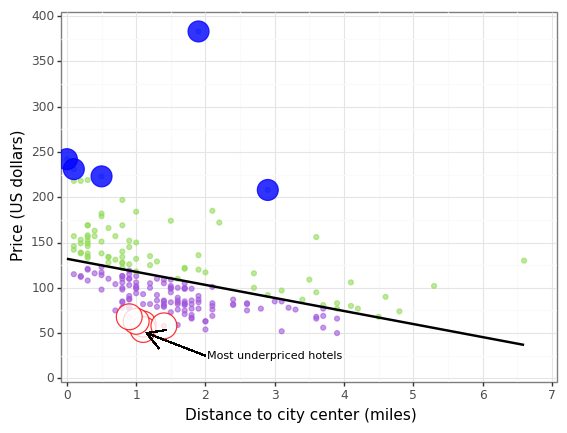

<ggplot: (679571616)>

In [36]:
(
    ggplot(hotels, aes(x="distance", y="price"))
    + geom_point(aes(color="reg1_res"), alpha=0.6)
    + geom_point(
        hotels.loc[lambda x: x["reg1_res"] == "top5"], alpha=0.8, size=8, color="blue"
    )
    + geom_point(
        hotels.loc[lambda x: x["reg1_res"] == "bottom5"],
        alpha=0.8,
        size=10,
        color="red",
        fill="white",
    )
    + geom_smooth(method="lm", size=1, se=False, formula="y~x")
    + coord_cartesian(xlim=(0, 7), ylim=(0, 400))
    + expand_limits(x=0.01, y=0.01)
    + scale_color_discrete(guide=False)
    + scale_x_continuous(expand=(0.01, 0.01), limits=(0, 7), breaks=np.arange(0, 8, 1))
    + scale_y_continuous(
        expand=(0.01, 0.01), limits=(0, 400), breaks=np.arange(0, 401, 50)
    )
    + labs(x="Distance to city center (miles)", y="Price (US dollars)")
    + geom_segment(aes(x=2, y=25, xend=1.15, yend=50), arrow=arrow())
    + annotate("text", x=3, y=25, label="Most underpriced hotels", size=8)
    + theme_bw()
)